In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'image-super-resolution:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F810739%2F1388983%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240129%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240129T190614Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4271ffc0df257dda2167c1e867b027977488d06f92838a94cbc26f35b872d85e2c04e0776d3d396ca1d8660b855254c366066b2603d59897fd8b5516b43596561f2cc7c4e03a4952afa176c376c7277ec8cffd4a3454c030ebef00ee814e17ff26731082d8c263ef1a7418300e0918c91d0b6fe6a1b41d0e07f40ceb07a1f4cf79f7fa5c418f2ad6d3758ae0165c9e70461b840fb13be8f3a18d5762037cef075d0699cfda0ffc0c35d2764159cef52d482f6a6a070bac0d42884e21ff57a10f493a4f1dccb06956f006d4fb8b8d9e8f8bfa9ccbd7b59aa8a2075c8228d5e419dda284889bef9e9a1ff8c630da783471afa08d7b59d40f6df3e68757edef0f2d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 315386246 bytes downloaded
Downloaded and uncompressed: image-super-resolution
Data source import complete.


In [2]:
!pip install Augmentor

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import Augmentor
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import normalize
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, add, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import datetime
from tensorflow.keras.models import load_model
import plotly.graph_objects as go
from plotly.subplots import make_subplots

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict())
except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime. Change your runtime type to "TPU" in Colab.')


resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

Running on TPU  {'worker': ['10.63.34.162:8470']}


In [31]:
working_directory = '/kaggle/working/'

files_and_directories = os.listdir(working_directory)

for file_or_directory in files_and_directories:
    full_path = os.path.join(working_directory, file_or_directory)

    try:
        if os.path.isfile(full_path):
            os.remove(full_path)
        elif os.path.isdir(full_path):
            shutil.rmtree(full_path)
    except Exception as e:
        print(f"Error deleting {file_or_directory}: {e}")

print(f"Contents of {working_directory} cleared.")


Contents of /kaggle/working/ cleared.


In [32]:
low_res_path_train = "/kaggle/input/image-super-resolution/dataset/train/low_res"
high_res_path_train = "/kaggle/input/image-super-resolution/dataset/train/high_res"

low_res_path_val = "/kaggle/input/image-super-resolution/dataset/val/low_res"
high_res_path_val = "/kaggle/input/image-super-resolution/dataset/val/high_res"

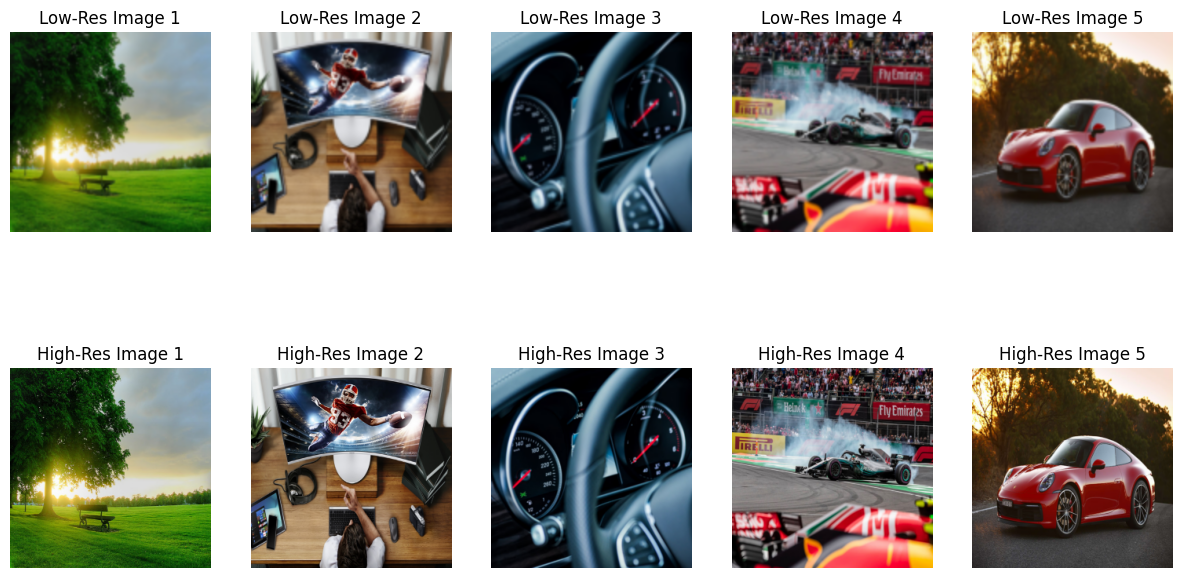

In [33]:
def display_original_images(low_res_path, high_res_path, num_images=5):
    low_res_images = os.listdir(low_res_path)
    high_res_images = os.listdir(high_res_path)

    selected_images = random.sample(low_res_images, min(num_images, len(low_res_images)))

    plt.figure(figsize=(15, 8))

    for i, image_name in enumerate(selected_images, 1):
        image_path_low_res = os.path.join(low_res_path, image_name)
        image_path_high_res = os.path.join(high_res_path, image_name)

        img_low_res = mpimg.imread(image_path_low_res)
        img_high_res = mpimg.imread(image_path_high_res)

        plt.subplot(2, num_images, i)
        plt.imshow(img_low_res)
        plt.axis('off')
        plt.title(f'Low-Res Image {i}')

        plt.subplot(2, num_images, i + num_images)
        plt.imshow(img_high_res)
        plt.axis('off')
        plt.title(f'High-Res Image {i}')

    plt.show()

display_original_images(low_res_path_train, high_res_path_train)

In [34]:
def count_images(directory):
    return len(os.listdir(directory))

original_low_res_train = "/kaggle/input/image-super-resolution/dataset/train/low_res"
original_high_res_train = "/kaggle/input/image-super-resolution/dataset/train/high_res"

print(f"Number of images in original low-res training set: {count_images(original_low_res_train)}")
print(f"Number of images in original high-res training set: {count_images(original_high_res_train)}")

Number of images in original low-res training set: 685
Number of images in original high-res training set: 685


In [52]:
image_size = (256,256)

def preprocess_images(directory, image_size):
    image_list = []

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        img = cv2.imread(filepath)
        img = cv2.resize(img, image_size)
        img = normalize(img)
        img = img.astype(np.float32)
        image_list.append(img)

    return np.array(image_list)


original_low_res_train = "/kaggle/input/image-super-resolution/dataset/train/low_res"
original_high_res_train = "/kaggle/input/image-super-resolution/dataset/train/high_res"

train_low_res_images = preprocess_images(original_low_res_train, image_size)
train_high_res_images = preprocess_images(original_high_res_train, image_size)

In [53]:
image_size = (256,256)

def preprocess_images(directory, image_size):
    image_list = []

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        img = cv2.imread(filepath)
        img = cv2.resize(img, image_size)
        img = normalize(img)
        img = img.astype(np.float32)
        image_list.append(img)

    return np.array(image_list)

original_low_res_train = "/kaggle/input/image-super-resolution/dataset/train/low_res"
original_high_res_train = "/kaggle/input/image-super-resolution/dataset/train/high_res"

original_low_res_val = "/kaggle/input/image-super-resolution/dataset/val/low_res"
original_high_res_val = "/kaggle/input/image-super-resolution/dataset/val/high_res"

train_low_res_images = preprocess_images(original_low_res_train, image_size)
train_high_res_images = preprocess_images(original_high_res_train, image_size)

val_low_res_images = preprocess_images(original_low_res_val, image_size)
val_high_res_images = preprocess_images(original_high_res_val, image_size)

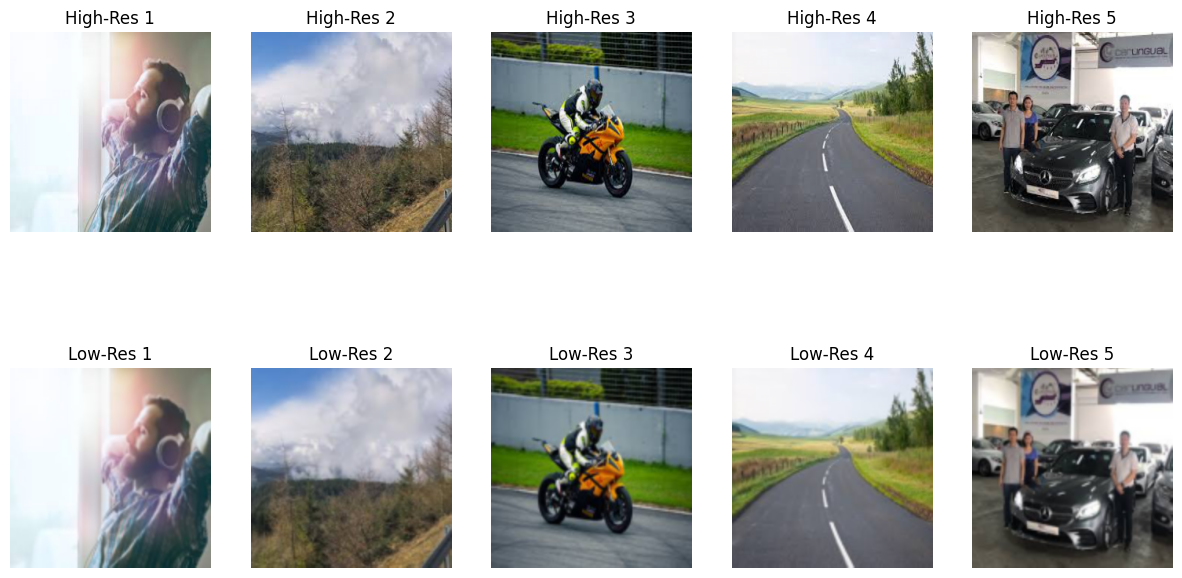

In [54]:
def display_comparison(images_hr, images_lr, num_images=5):
    plt.figure(figsize=(15, 8))

    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        img_hr = cv2.cvtColor(images_hr[i], cv2.COLOR_BGR2RGB)
        plt.imshow(img_hr, cmap='gray', vmin=0, vmax=255)
        plt.axis('off')
        plt.title(f'High-Res {i + 1}')

        plt.subplot(2, num_images, i + num_images + 1)
        img_lr = cv2.cvtColor(images_lr[i], cv2.COLOR_BGR2RGB)
        plt.imshow(img_lr, cmap='gray', vmin=0, vmax=255)
        plt.axis('off')
        plt.title(f'Low-Res {i + 1}')

    plt.show()

display_comparison(train_high_res_images, train_low_res_images, num_images=5)


In [96]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, add, UpSampling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf
with strategy.scope():
    def lr_scheduler(epoch, lr):
        if epoch % 10 == 0 and epoch > 0:
            lr = lr * 0.9
        return lr

    def perceptual_loss(y_true, y_pred):
        scales = [1, 0.5, 0.25, 0.125]
        ssim_loss = 0
        for scale in scales:
            y_true_scaled = tf.image.resize(y_true, (int(input_shape[0] * scale), int(input_shape[1] * scale)))
            y_pred_scaled = tf.image.resize(y_pred, (int(input_shape[0] * scale), int(input_shape[1] * scale)))
            ssim_loss += 1 - tf.reduce_mean(tf.image.ssim(y_true_scaled, y_pred_scaled, 1.0))
        return ssim_loss / len(scales)

    def subpixel_conv2d(x):
        return tf.nn.depth_to_space(x, 2)

    input_shape = (256, 256, 3)
    input_img = Input(shape=input_shape)

    l1 = Conv2D(256, (3, 3), padding='same', activation='relu')(input_img)
    l2 = BatchNormalization()(l1)
    l3 = Conv2D(128, (3, 3), padding='same', activation='relu')(l2)
    l4 = BatchNormalization()(l3)
    l5 = MaxPooling2D(padding='same')(l4)
    l5 = Dropout(0.3)(l5)
    l6 = Conv2D(256, (3, 3), padding='same', activation='relu')(l5)
    l7 = BatchNormalization()(l6)
    l8 = Conv2D(256, (3, 3), padding='same', activation='relu')(l7)
    l9 = BatchNormalization()(l8)
    l10 = MaxPooling2D(padding='same')(l9)
    l11 = Conv2D(512, (3, 3), padding='same', activation='relu')(l10)

    l12 = Lambda(subpixel_conv2d)(l11)
    l13 = Conv2D(256, (3, 3), padding='same', activation='relu')(l12)
    l14 = BatchNormalization()(l13)
    l15 = Conv2D(256, (3, 3), padding='same', activation='relu')(l14)
    l16 = BatchNormalization()(l15)
    l17 = add([l9, l16])
    l18 = Lambda(subpixel_conv2d)(l17)
    l19 = Conv2D(128, (3, 3), padding='same', activation='relu')(l18)
    l20 = BatchNormalization()(l19)
    l21 = Conv2D(128, (3, 3), padding='same', activation='relu')(l20)
    l22 = BatchNormalization()(l21)
    l23 = add([l22, l4])

    decoded = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(l23)

    autoencoder = Model(input_img, decoded)

    autoencoder.compile(optimizer=RMSprop(), loss=perceptual_loss, metrics=['accuracy'])

    lr_schedule = LearningRateScheduler(lr_scheduler)
    callbacks_list = [lr_schedule]

    autoencoder.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_90 (Conv2D)             (None, 256, 256, 25  7168        ['input_10[0][0]']               
                                6)                                                                
                                                                                                  
 batch_normalization_56 (BatchN  (None, 256, 256, 25  1024       ['conv2d_90[0][0]']              
 ormalization)                  6)                                                          

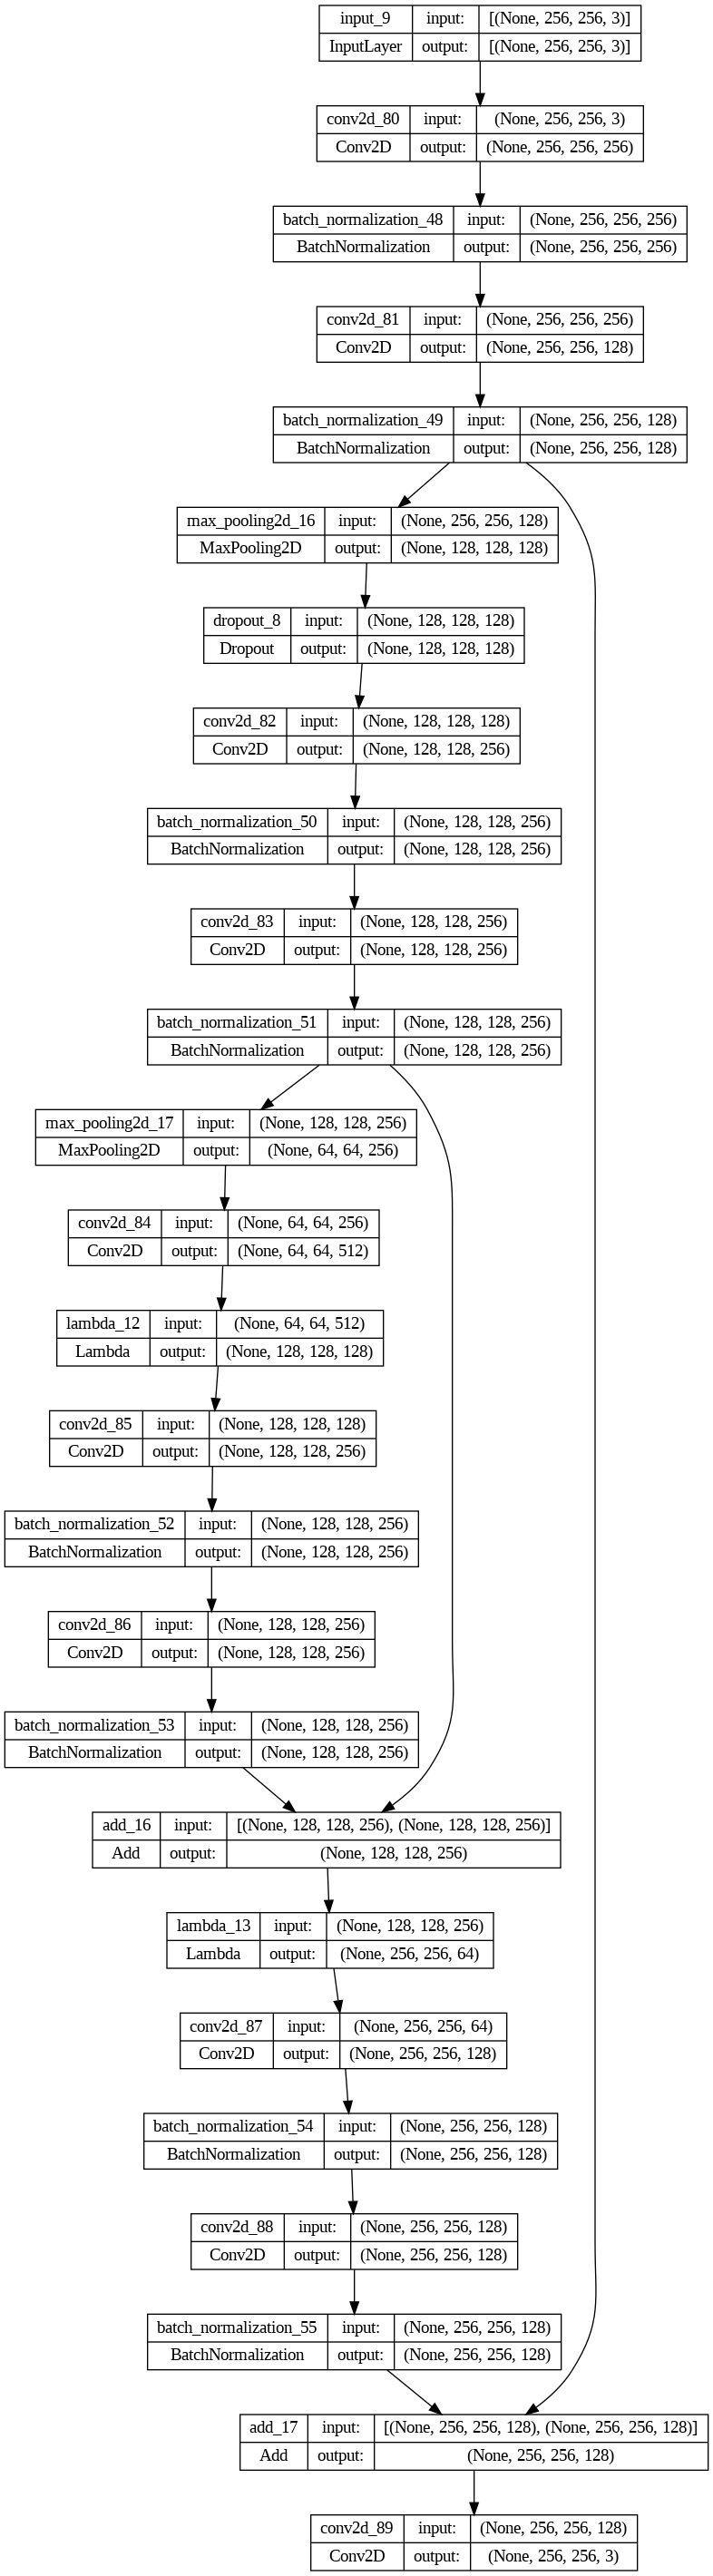

In [73]:
plot_model(autoencoder,

           to_file='keras_model_plot.png',

           show_shapes=True,

           show_layer_names=True)

In [74]:
history = autoencoder.fit(
        train_low_res_images, train_high_res_images,
        epochs=100,
        batch_size=64,
        validation_data=(val_low_res_images, val_high_res_images),
    )

Epoch 1/100
11/11 [==============================] - 170s 11s/step - loss: 0.4999 - accuracy: 0.4792 - val_loss: nan - val_accuracy: 0.4087
Epoch 2/100
11/11 [==============================] - 14s 1s/step - loss: 0.2665 - accuracy: 0.4964 - val_loss: nan - val_accuracy: 0.4426
Epoch 3/100
11/11 [==============================] - 13s 1s/step - loss: 0.1747 - accuracy: 0.6022 - val_loss: nan - val_accuracy: 0.5354
Epoch 4/100
11/11 [==============================] - 14s 1s/step - loss: 0.1607 - accuracy: 0.6084 - val_loss: nan - val_accuracy: 0.3676
Epoch 5/100
11/11 [==============================] - 13s 1s/step - loss: 0.1428 - accuracy: 0.5842 - val_loss: nan - val_accuracy: 0.5575
Epoch 6/100
11/11 [==============================] - 14s 1s/step - loss: 0.1378 - accuracy: 0.5903 - val_loss: nan - val_accuracy: 0.2477
Epoch 7/100
11/11 [==============================] - 13s 1s/step - loss: 0.1222 - accuracy: 0.5630 - val_loss: nan - val_accuracy: 0.4843
Epoch 8/100
11/11 [=============

In [77]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.7 MB/s eta 0:00:00


In [87]:
autoencoder.save("autoencoder_final.keras")

In [97]:
from tensorflow.keras.models import load_model
custom_objects = {'perceptual_loss': perceptual_loss}
loaded_autoencoder = load_model("autoencoder_final.keras", custom_objects=custom_objects)

In [83]:
loaded_autoencoder = load_model("autoencoder_final.keras")fig = make_subplots(rows=2, cols=1, subplot_titles=['Model Accuracy Over Epochs', 'Model Loss Over Epochs'],
                    shared_xaxes=True, vertical_spacing=0.1)

fig.add_trace(go.Scatter(x=history.epoch, y=history.history['accuracy'], mode='lines', name='Train', line=dict(color='lime')),
              row=1, col=1)
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_accuracy'], mode='lines', name='Test', line=dict(color='cyan')),
              row=1, col=1)

fig.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], mode='lines', name='Train', line=dict(color='lime')),
              row=2, col=1)
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], mode='lines', name='Test', line=dict(color='cyan')),
              row=2, col=1)

fig.update_layout(title_text='Model Training Metrics Over Epochs',
                  xaxis=dict(title='Epoch'),
                  font=dict(color='white'),
                  paper_bgcolor='black',
                  plot_bgcolor='black',
                  legend=dict(x=0, y=1, traceorder='normal'))

fig.show()

27/27 [==============================] - 4s 147ms/step


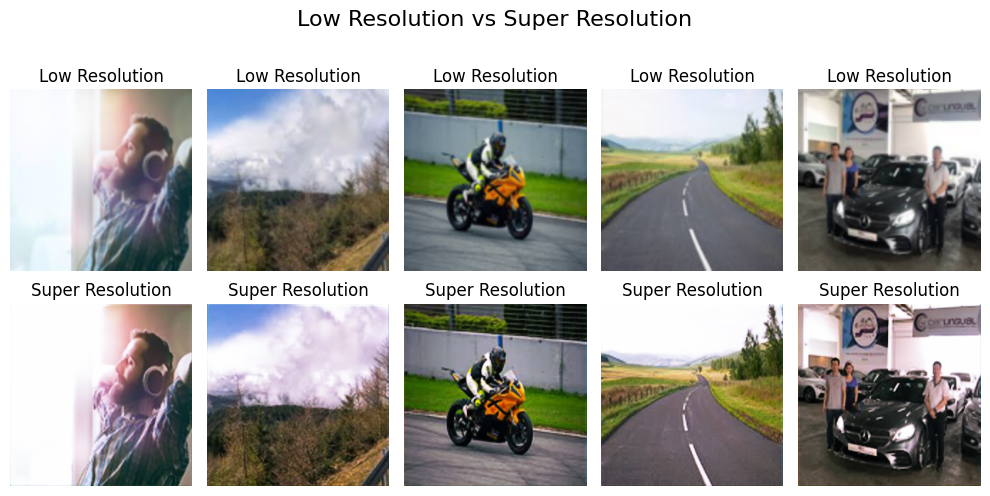

In [92]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

image_size = (256, 256)

def normalize(img):
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return img

def preprocess_images(directory, image_size):
    image_list = []

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        img = cv2.imread(filepath)
        img = cv2.resize(img, image_size)
        img = normalize(img)
        image_list.append(img)

    return np.array(image_list)

def enhance_images(model, low_res_images):
    low_res_images = low_res_images.reshape((len(low_res_images), image_size[0], image_size[1], 3))
    enhanced_images = model.predict(low_res_images)
    enhanced_images = enhanced_images.reshape((len(enhanced_images), image_size[0], image_size[1], 3))

    return enhanced_images

loaded_model = autoencoder

input_directory = "/kaggle/input/image-super-resolution/dataset/Raw Data/low_res"

low_res_images = preprocess_images(input_directory, image_size)

enhanced_images = enhance_images(loaded_model, low_res_images)

plt.figure(figsize=(10, 5))

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(low_res_images[i], cv2.COLOR_BGR2RGB))
    plt.title('Low Resolution')
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(cv2.cvtColor(enhanced_images[i], cv2.COLOR_BGR2RGB))
    plt.title('Super Resolution')
    plt.axis('off')

plt.suptitle("Low Resolution vs Super Resolution", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


27/27 [==============================] - 5s 151ms/step


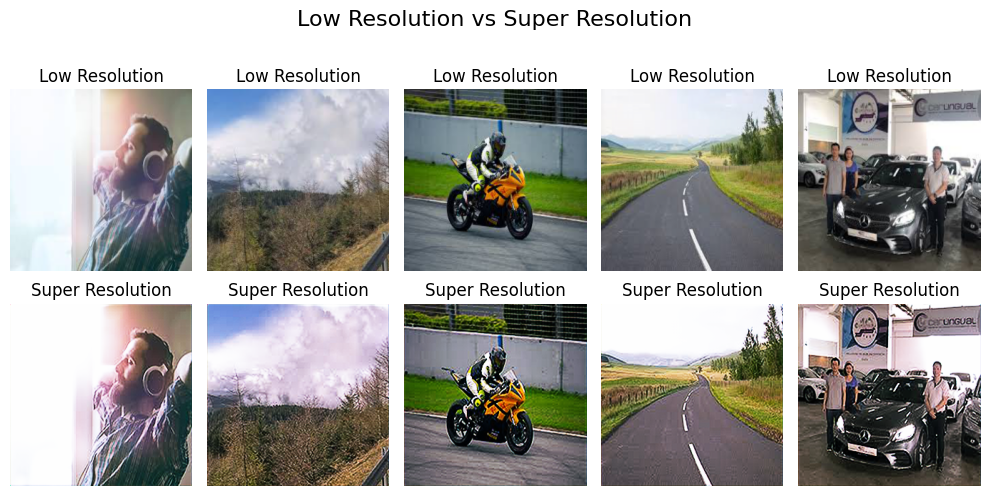

In [93]:
input_directory = "/kaggle/input/image-super-resolution/dataset/Raw Data/high_res"

low_res_images = preprocess_images(input_directory, image_size)

enhanced_images = enhance_images(loaded_model, low_res_images)

plt.figure(figsize=(10, 5))

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(low_res_images[i], cv2.COLOR_BGR2RGB))
    plt.title('Low Resolution')
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(cv2.cvtColor(enhanced_images[i], cv2.COLOR_BGR2RGB))
    plt.title('Super Resolution')
    plt.axis('off')

plt.suptitle("Low Resolution vs Super Resolution", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()